<center><font size="4"><span style="color:blue">Demonstration 1: benchmark for impact of using simulated and drawn instances</span></font></center>

This is a demonstration of a specific challenge (benchmark) that practitioners and researchers can use together with the 3W dataset, and that is defined in the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

**_Disclamer_**

_This notebook presents a demonstration. As we have not experienced all the possibilities, for example in terms of approaches, methods, parameter values, and metrics, we do not argue that the results presented here are optimal. However, these results can be used as initial benchmark for other works._

# 1. Choices

The more relevant choices of the method implemented for this demonstration are:

1. Only real instances with undesirable events of the type 1 are used. The types of events that do not have transient period are not appropriate for this demonstration. This type of event has few real instances and also has simulated and drawn instances;
1. As the event type 1 has a slow dynimics, it is applied downsample in all the instances;
1. The considered metrics are calculated globally by counting the total true positives, false negatives and false positives. Samples from transient and in-regime periods are grouped as abnormal;
1. The possible concept drift of normality is not considered. The used method supposes that normality and the undesirable events do not depend on time or specific well;
1. Only classifiers (four in total) implemented in the scikit-learn package are used. As optimization of metrics is not a focus of this work, the parameters of the classifiers are not optimized;
1. A specific sampling strategy with sliding window is used for each type of period of training instances. In normal periods, the last observations are privileged. In transient periods, it is sought to use observations throughout the transient as a whole. In in-regime periods, the first observations are privileged;
1. The sampling strategy in testing instances is different. Information about the periods are not used and it is sought to use observations throughout the instance as a whole;
1. Before each round of training and testing:
    1. The used instances are appropriately normalized with z-score;
    1. The variables of real instances used for training that have a number of NaNs above a threshold or that have a standard deviation below another threshold are discarded.
1. For the sake of execution time, it is used a subset of the minimal set of features of the tsfresh package. Other features can improve the classifiers performances;
1. All required random_state are assigned to a constant for results to be reproducible;
1. Part of rule 3 is violated. The testing set is not always composed of the same number of samples of each label (positive and negative). This needs to be addressed in future work, possibly with an updated version of the 3W dataset. The difficulty is because real instances have slow dynamics and short normal periods. This makes it difficult to establish a window small enough for the rule to be respected and long enough for the dynamics to be learned.

# 2. Imports and Configurations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
import sys
sys.path.append('stac')
import nonparametric_tests as stac
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

In [2]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [4]:
data_path = Path('.', 'data')
random_state = 1
n_jobs = None
clfs = {'Decision Tree':     DecisionTreeClassifier(random_state=random_state),
        'AdaBoost':          AdaBoostClassifier(random_state=random_state),
        'Random Forest':     RandomForestClassifier(n_jobs=n_jobs, random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state)
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class']
normal_class_code = 0
undesirable_event_code = 1      # Undesirable event of interest
downsample_rate = 60            # Adjusts frequency of sampling to the dynamics 
                                # of the undesirable event of interest
sample_size_default = 60        # In observations (after downsample)
sample_size_normal_period = 5   # In observations (after downsample)
max_samples_per_period = 15     # Limitation for safety
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
max_nan_percent = 0.1           # For selection of useful variables
std_vars_min = 0.01             # For selection of useful variables
disable_progressbar = True      # For less output

In [5]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [16]:
def get_instances_with_undesirable_event(data_path, undesirable_event_code,
                                         real, simulated, drawn):
    instances = pd.DataFrame(class_and_file_generator(data_path,
                                                      real=real,
                                                      simulated=simulated, 
                                                      drawn=drawn),
                             columns=['class_code', 'instance_path'])
    idx = instances['class_code'] == undesirable_event_code
    return instances.loc[idx].reset_index(drop=True)

In [17]:
def load_instance(instance_path):
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), 'invalid columns in the file {}: {}'\
            .format(str(instance_path), str(df.columns.tolist()))
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [18]:
def load_and_downsample_instances(instances, downsample_rate, source, instance_id):
    df_instances = pd.DataFrame()
    for _, row in instances.iterrows():
        _, instance_path = row
        df = load_instance(instance_path).iloc[::downsample_rate, :]
        df['instance_id'] = instance_id
        instance_id += 1
        df_instances = pd.concat([df_instances, df])
    df_instances['source'] = source
    return df_instances.reset_index(drop=True), instance_id

In [19]:
def extract_samples_train(df, df_samples_train, df_y_train, sample_id):
    instance = df['instance_id'].iloc[0]
    f_idxs = []
    l_idxs = []
    
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))
    
    # Discards the source and the observations labels and replaces all nan with 
    # 0 (tsfresh's requirement)
    df_vars = df.drop(['source', 'class'], axis=1).fillna(0)

    # Extracts samples from the normal period (if it exists)
    #
    if normal_class_code in set_ols:
        # Gets indexes (first and last) without overlap with other periods
        f_idx = ols.index(normal_class_code)
        l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_normal_period
        if (max_samples) > 0:  
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size_normal_period
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = l_idx-sample_size_normal_period+1-(num_samples-1-idx)*step
                l_idx_c = f_idx_c+sample_size_normal_period
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)                
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':normal_class_code},
                                               ignore_index=True)
                sample_id += 1

    # Extracts samples from the transient period (if it exists)
    #
    transient_code = undesirable_event_code + 100
    if transient_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size_default-1) > 0:
            f_idx = f_idx-(sample_size_default-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
    
        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_default
        if (max_samples) > 0:
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = np.inf
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size_default
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)                
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':transient_code},
                                               ignore_index=True)
                sample_id += 1
    
    # Extracts samples from the in-regime period (if it exists)
    #
    if undesirable_event_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # or end of this period
        f_idx = ols.index(undesirable_event_code)
        if f_idx-(sample_size_default-1) > 0:
            f_idx = f_idx-(sample_size_default-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(undesirable_event_code)
        if l_idx+(sample_size_default-1) < len(ols)-1:
            l_idx = l_idx+(sample_size_default-1) 
        else:
            l_idx = len(ols)-1
  
        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_default
        if (max_samples) > 0 :
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size_default
            step = min(step_wanted, step_max)
    
            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size_default
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':undesirable_event_code}, 
                                               ignore_index=True)
                sample_id += 1
    
    return df_samples_train, df_y_train, sample_id 

In [20]:
def extract_samples_test(df, df_samples_test, df_y_test, sample_id):
    instance = df['instance_id'].iloc[0]
    f_idxs = []
    l_idxs = []
    
    # Gets the observations labels
    ols = list(df['class'].fillna(method='ffill'))    
    
    # Discards the source and the observations labels and replaces all nan with 
    # 0 (tsfresh's requirement)
    df_vars = df.drop(['source', 'class'], axis=1).fillna(0)    
    
    # Extracts samples from the instance as a whole
    f_idx = 0
    l_idx = len(df)-1  

    # Defines the proper step and extracts samples
    max_samples = l_idx-f_idx+1-sample_size_default
    if (max_samples) > 0:
        num_samples = min(3*max_samples_per_period, max_samples)
        if num_samples == max_samples:
            step_max = 1 
        else:
            step_max = (max_samples-1) // (3*max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)

        # Extracts samples
        for idx in range(num_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size_default
            f_idxs.append(f_idx_c)
            l_idxs.append(l_idx_c)                
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            df_y_test = df_y_test.append({'instance':instance, 'y':ols[l_idx_c]},
                                         ignore_index=True)
            sample_id += 1
            
    return df_samples_test, df_y_test, sample_id

In [21]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs, scenario):
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            clf.fit(X_train, y_train)
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
            
            # Plots actual and predicted labels
            fig = plt.figure(figsize=(12,1))
            ax = fig.add_subplot(111)
            plt.plot(y_pred, marker=11, color='orange', linestyle='')
            plt.plot(y_test, marker=10, color='green', linestyle='')            
            ax.grid(False)
            ax.set_yticks([0, undesirable_event_code])
            ax.set_yticklabels([normal_class_code, undesirable_event_code])
            ax.set_title(clf_name)
            ax.set_xlabel('Sample')
            ax.legend(['Predicted labels', 'Actual labels'])
            plt.show()
                  
            # Calculates the considered scores
            ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
            p, r, f1, _ = ret
            scores = scores.append({'SCENARIO': scenario,
                                    'CLASSIFIER': clf_name, 
                                    'PRECISION': p,
                                    'RECALL': r,
                                    'F1': f1,
                                    'TRAINING[s]': t_train, 
                                    'TESTING[s]': t_test}, ignore_index=True)
                                      
        except Exception as e:
            print('error in training/testing classifier: {}'.format(e))
            scores = scores.append({'SCENARIO': scenario,
                                    'CLASSIFIER': clf_name, 
                                    'PRECISION': np.nan,
                                    'RECALL': np.nan,
                                    'F1': np.nan,
                                    'TRAINING[s]': np.nan, 
                                    'TESTING[s]': np.nan}, ignore_index=True)
            
    return scores

In [22]:
def loio(n):
    all_i = range(n)
    for i in all_i:
        test_i = set([i])
        train_i = set(all_i)-test_i
        yield train_i, test_i

In [23]:
# Gets all real, simulated and drawn instances but maintains only those with 
# the specified undesirable event
real_instances = get_instances_with_undesirable_event(data_path, 
                                                      undesirable_event_code,
                                                      real=True,
                                                      simulated=False, 
                                                      drawn=False)
simul_instances = get_instances_with_undesirable_event(data_path,
                                                       undesirable_event_code,
                                                       real=False,
                                                       simulated=True, 
                                                       drawn=False)
drawn_instances = get_instances_with_undesirable_event(data_path,
                                                       undesirable_event_code,
                                                       real=False,
                                                       simulated=False, 
                                                       drawn=True)

In [24]:
# Loads all real, simulated and drawn instances and applies downsample
instance_id = 0
df_real_instances, instance_id  = load_and_downsample_instances(real_instances,
                                                                downsample_rate,
                                                                'real', 
                                                                instance_id)
df_simul_instances, instance_id = load_and_downsample_instances(simul_instances, 
                                                                downsample_rate,
                                                                'simulated', 
                                                                instance_id)
df_drawn_instances, instance_id = load_and_downsample_instances(drawn_instances,
                                                                downsample_rate,
                                                                'drawn', 
                                                                instance_id)
df_instances = pd.concat([df_real_instances, df_simul_instances, df_drawn_instances])

current testing instance: 0
	scenario 1 -> training with real {1, 2, 3, 4} +  instances


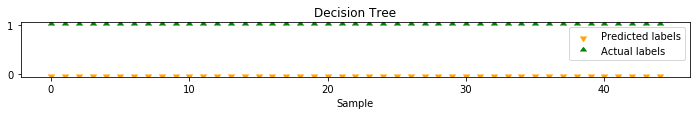

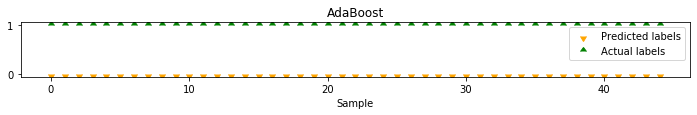

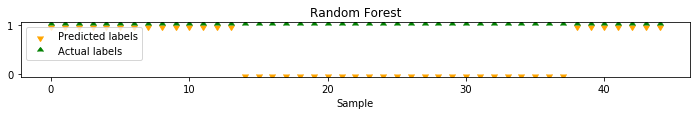

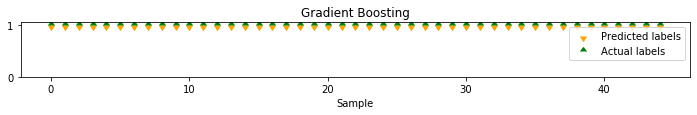

	scenario 2 -> training with simulated instances


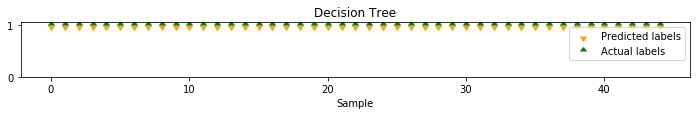

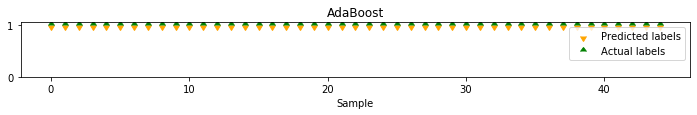

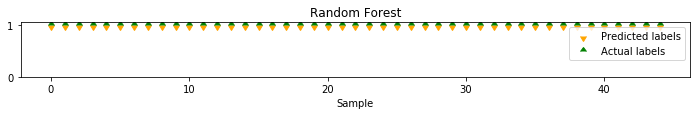

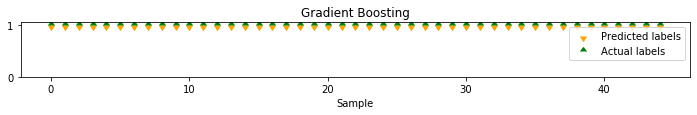

	scenario 3 -> training with drawn instances


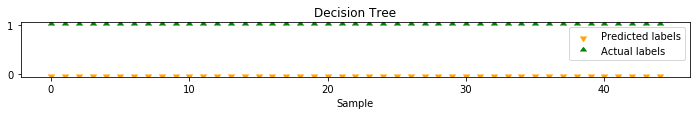

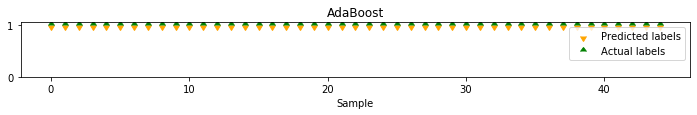

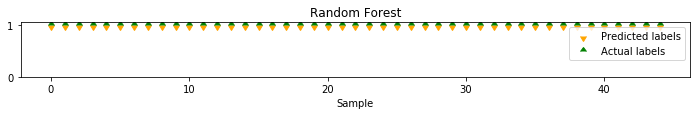

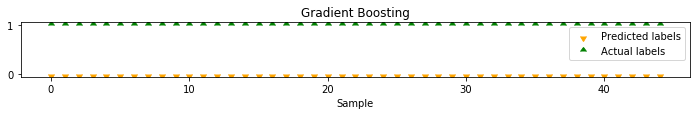

	scenario 4 -> training with real {1, 2, 3, 4} + simulated instances


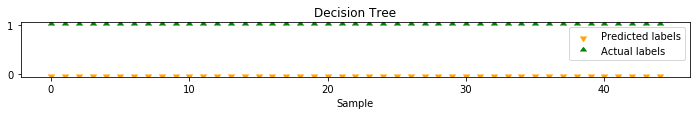

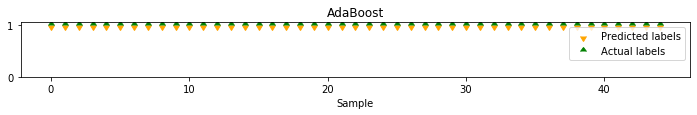

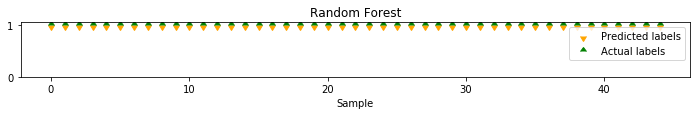

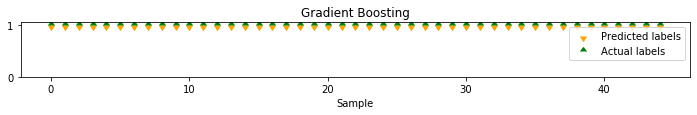

	scenario 5 -> training with real {1, 2, 3, 4} + drawn instances


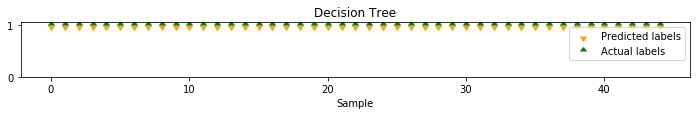

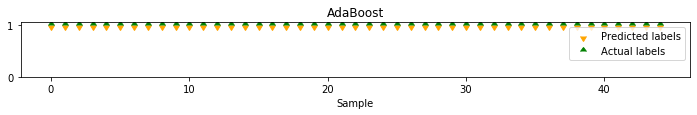

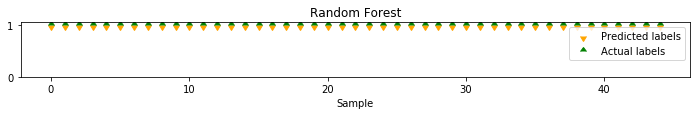

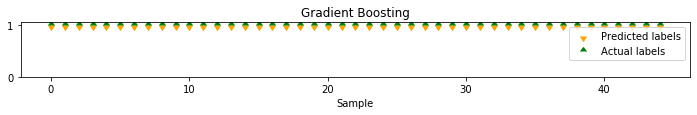

	scenario 6 -> training with simulated + drawn instances


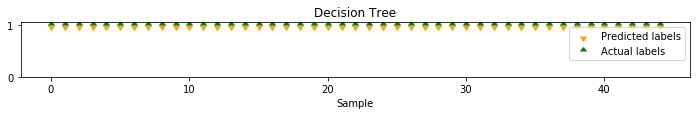

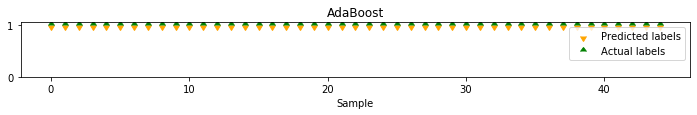

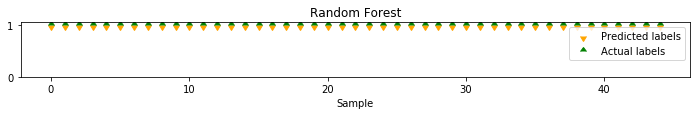

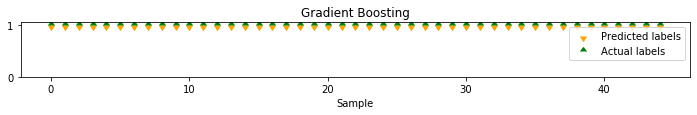

	scenario 7 -> training with real {1, 2, 3, 4} + simulated + drawn instances


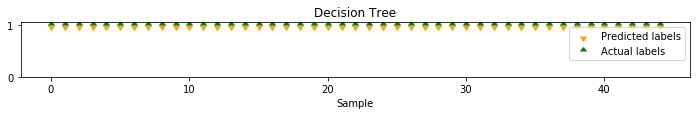

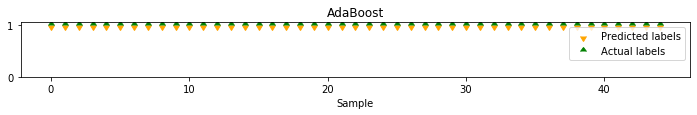

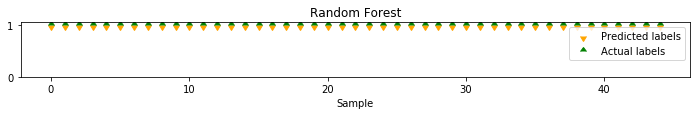

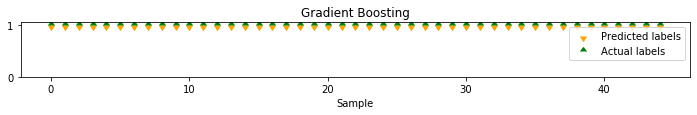

current testing instance: 1
	scenario 1 -> training with real {0, 2, 3, 4} +  instances


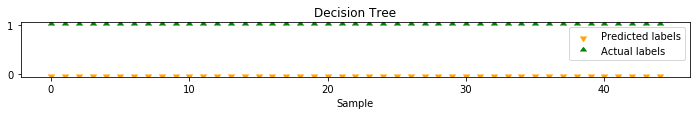

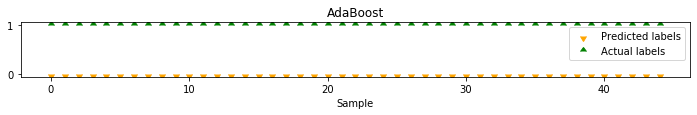

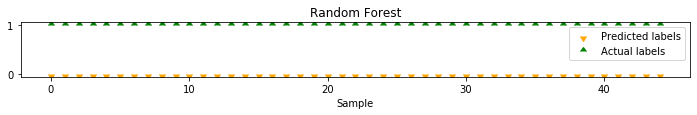

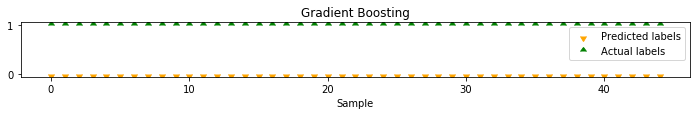

	scenario 2 -> training with simulated instances


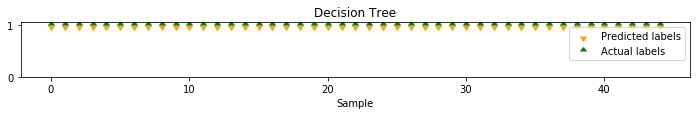

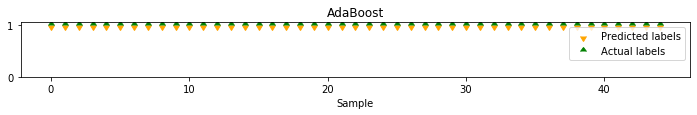

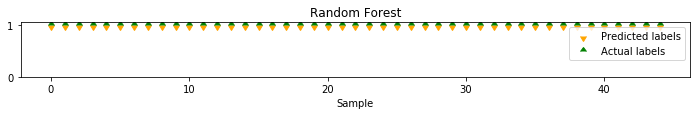

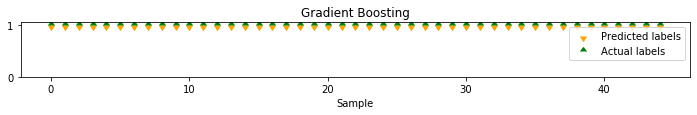

	scenario 3 -> training with drawn instances


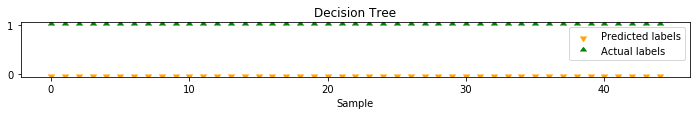

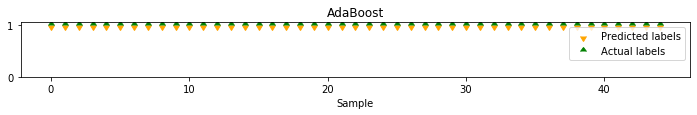

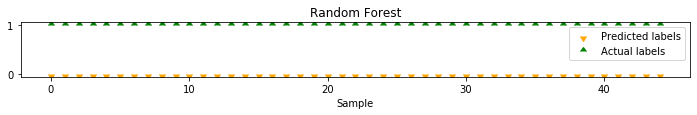

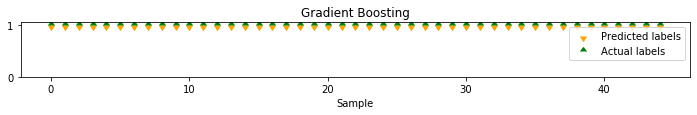

	scenario 4 -> training with real {0, 2, 3, 4} + simulated instances


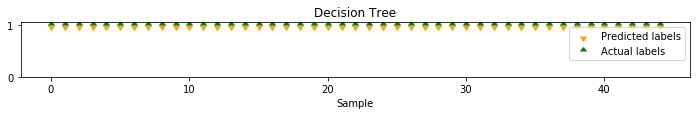

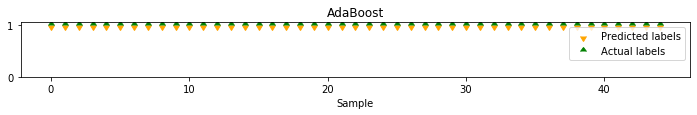

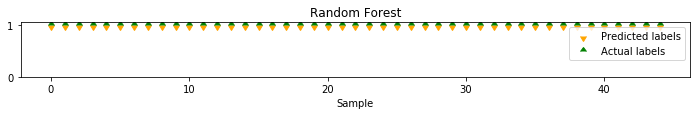

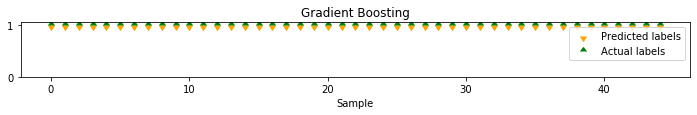

	scenario 5 -> training with real {0, 2, 3, 4} + drawn instances


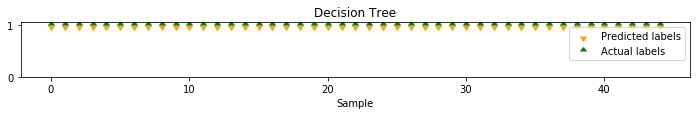

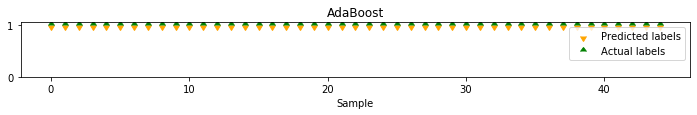

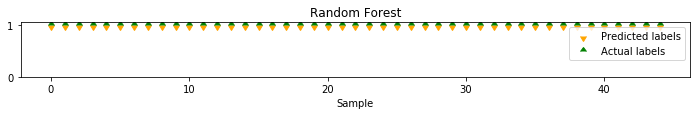

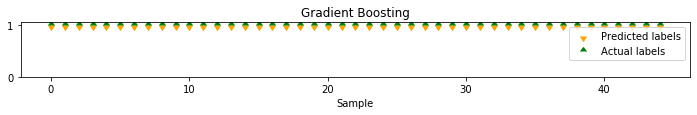

	scenario 6 -> training with simulated + drawn instances


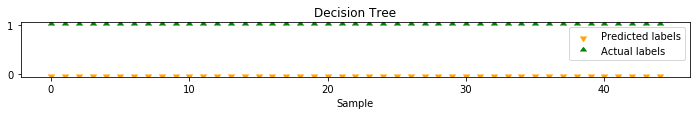

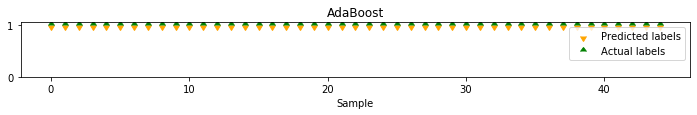

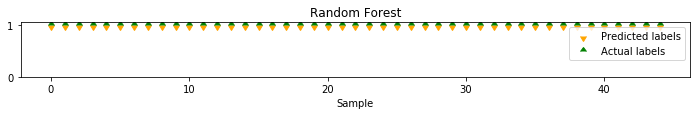

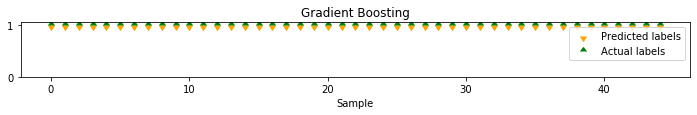

	scenario 7 -> training with real {0, 2, 3, 4} + simulated + drawn instances


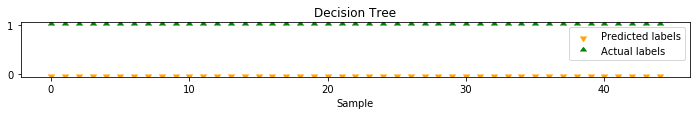

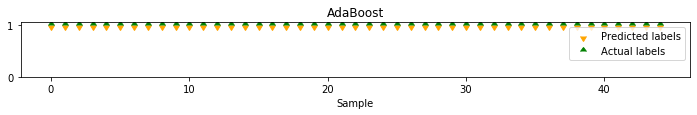

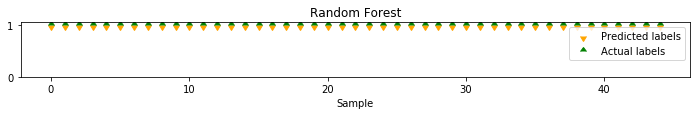

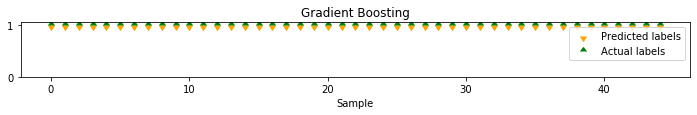

current testing instance: 2
	scenario 1 -> training with real {0, 1, 3, 4} +  instances


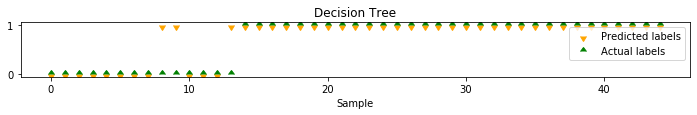

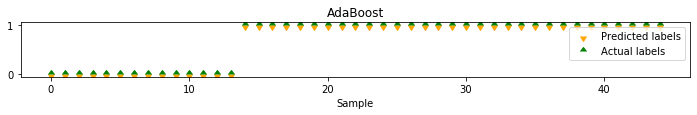

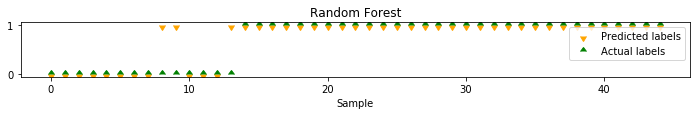

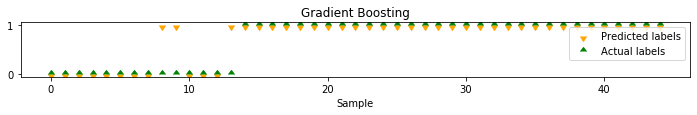

	scenario 2 -> training with simulated instances


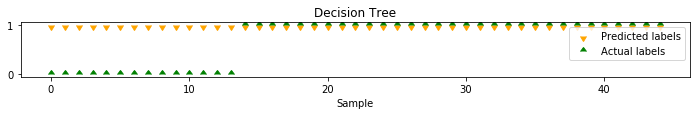

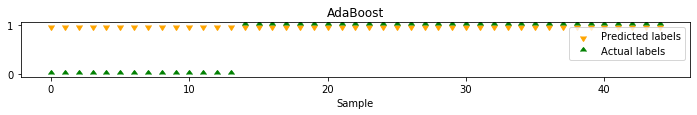

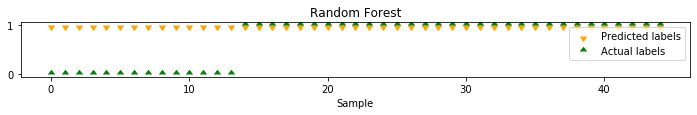

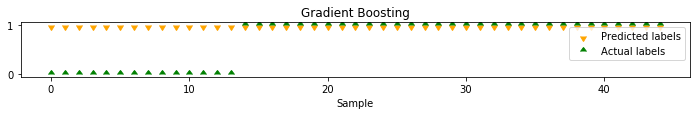

	scenario 3 -> training with drawn instances


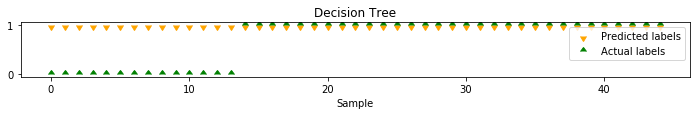

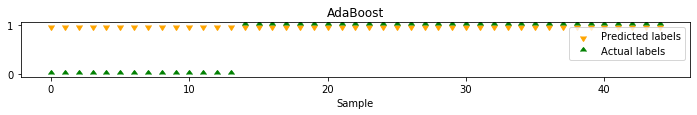

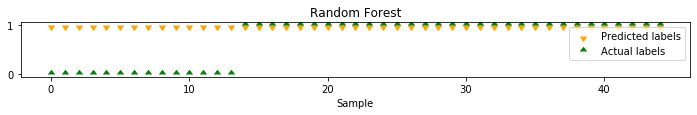

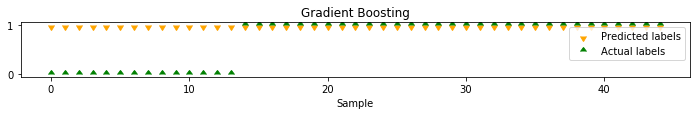

	scenario 4 -> training with real {0, 1, 3, 4} + simulated instances


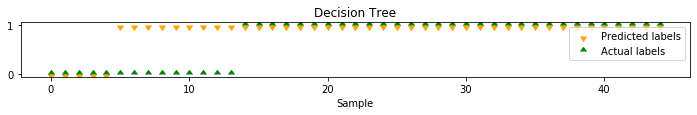

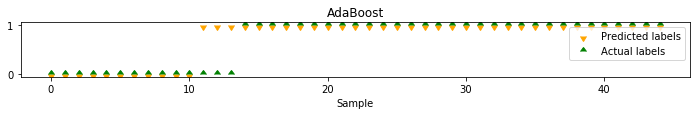

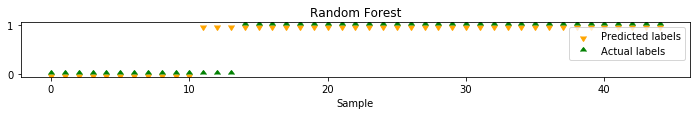

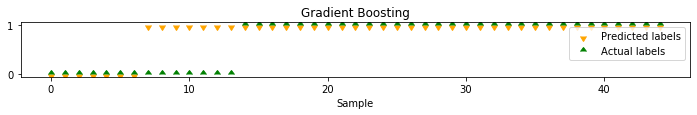

	scenario 5 -> training with real {0, 1, 3, 4} + drawn instances


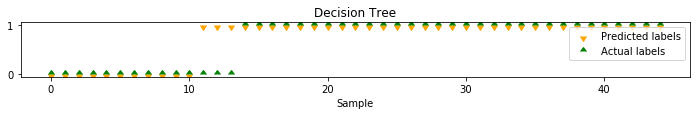

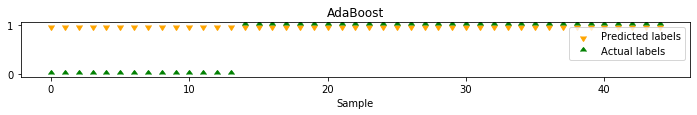

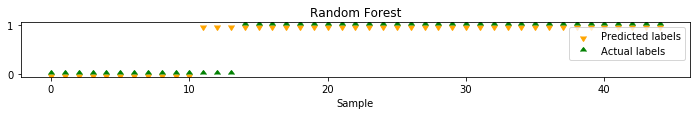

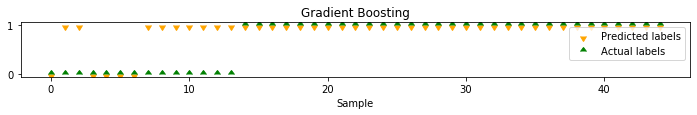

	scenario 6 -> training with simulated + drawn instances


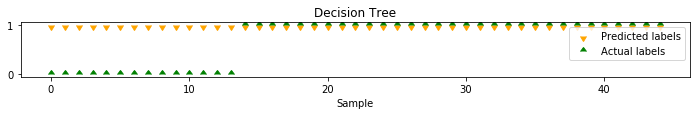

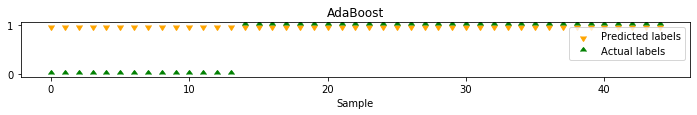

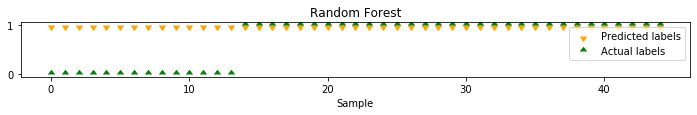

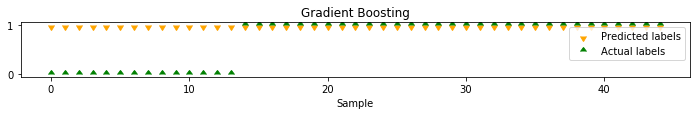

	scenario 7 -> training with real {0, 1, 3, 4} + simulated + drawn instances


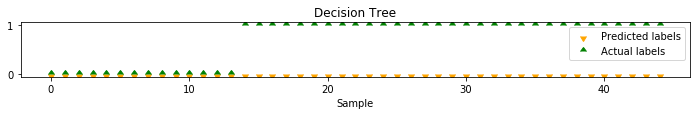

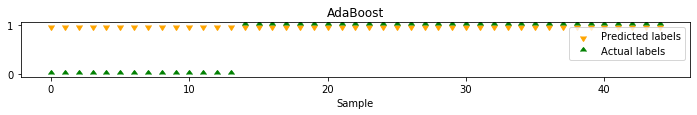

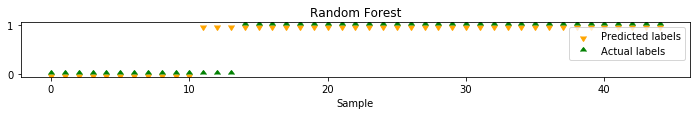

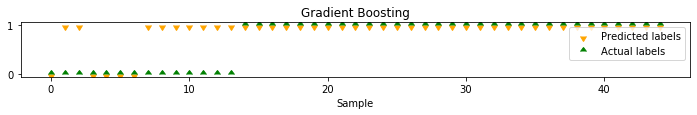

current testing instance: 3
	scenario 1 -> training with real {0, 1, 2, 4} +  instances


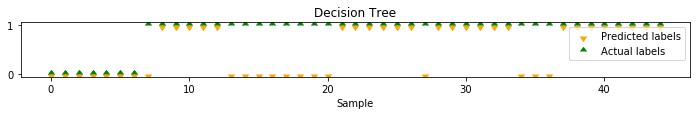

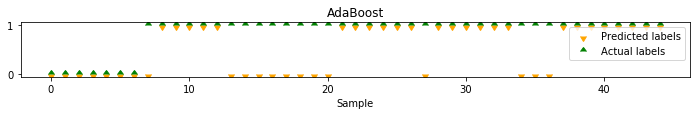

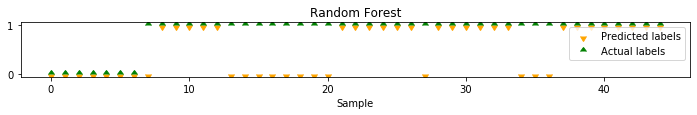

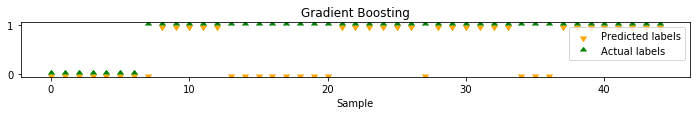

	scenario 2 -> training with simulated instances


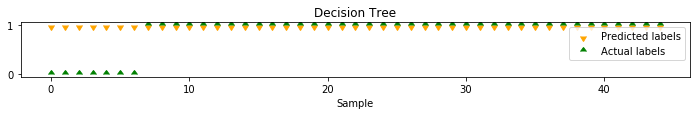

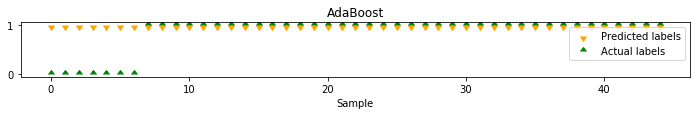

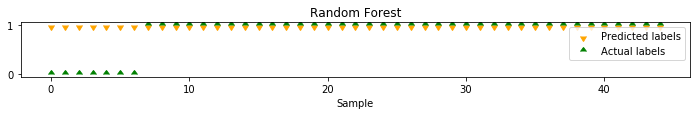

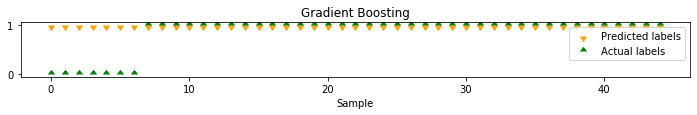

	scenario 3 -> training with drawn instances


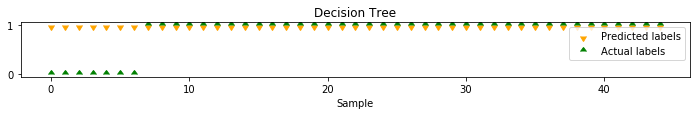

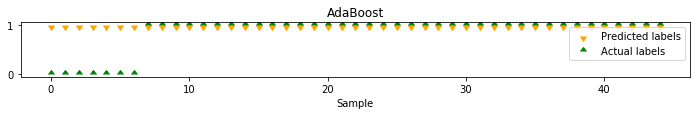

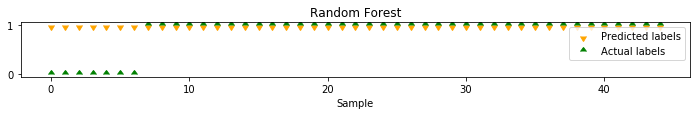

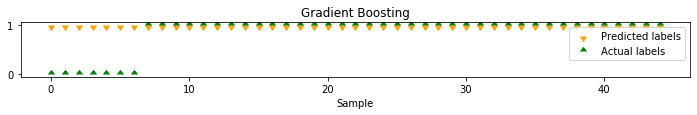

	scenario 4 -> training with real {0, 1, 2, 4} + simulated instances


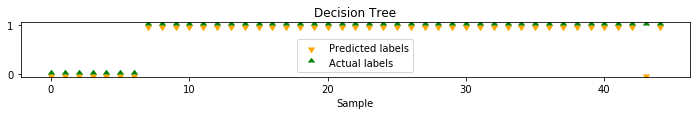

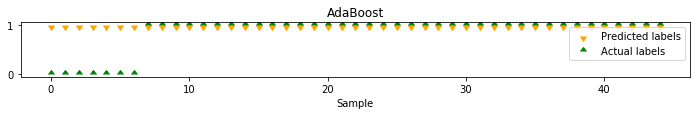

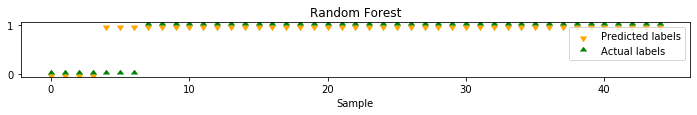

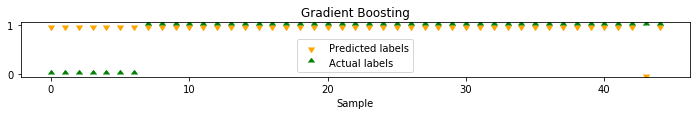

	scenario 5 -> training with real {0, 1, 2, 4} + drawn instances


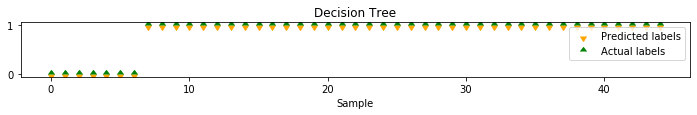

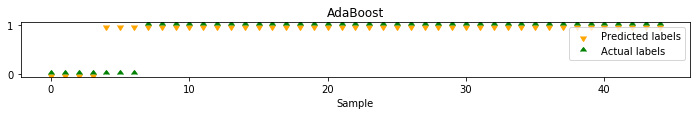

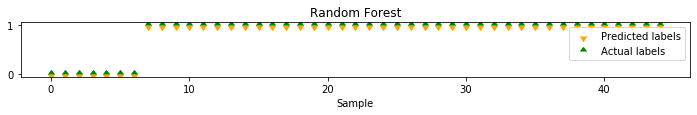

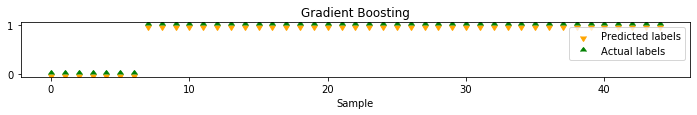

	scenario 6 -> training with simulated + drawn instances


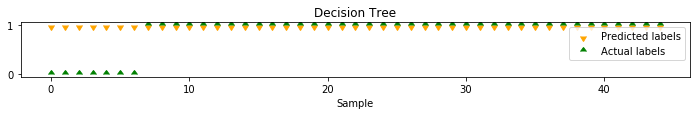

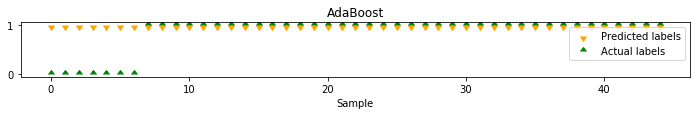

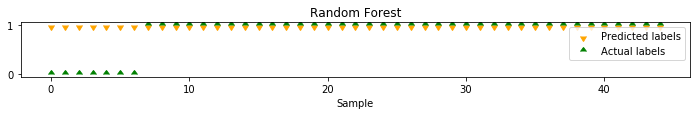

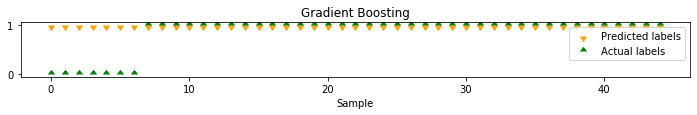

	scenario 7 -> training with real {0, 1, 2, 4} + simulated + drawn instances


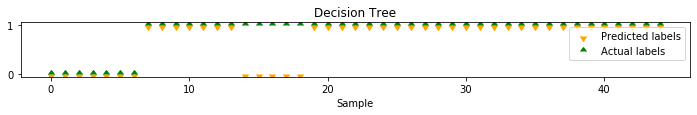

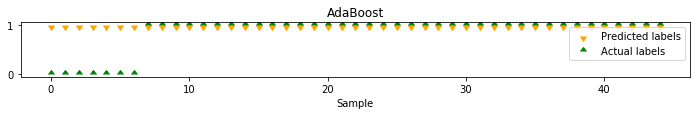

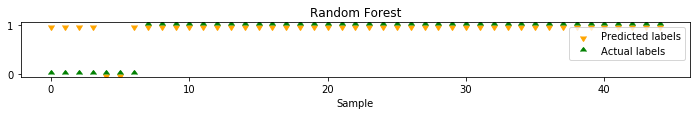

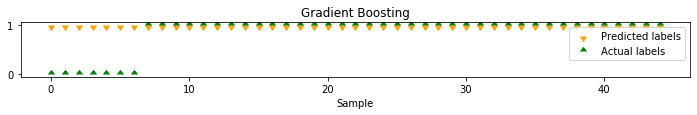

current testing instance: 4
	scenario 1 -> training with real {0, 1, 2, 3} +  instances


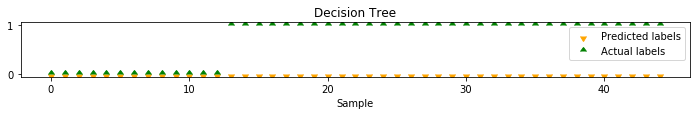

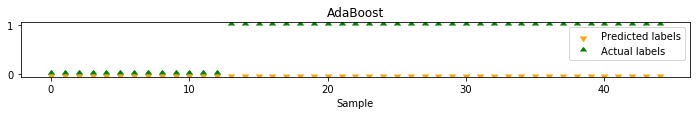

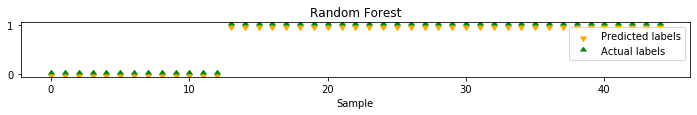

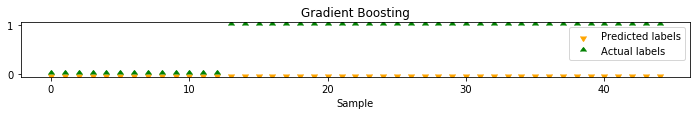

	scenario 2 -> training with simulated instances


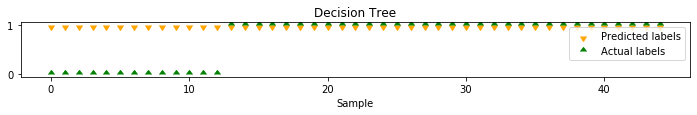

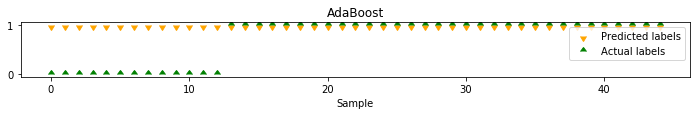

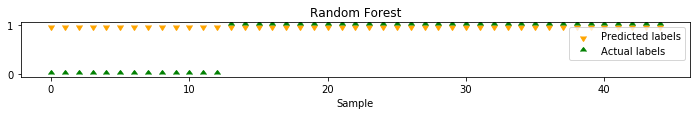

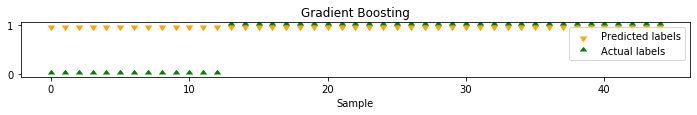

	scenario 3 -> training with drawn instances


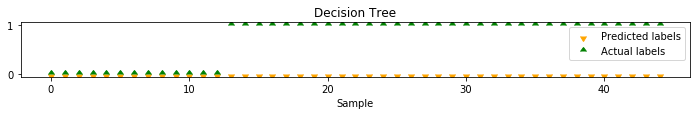

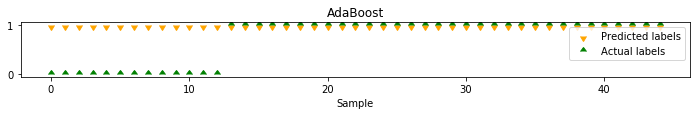

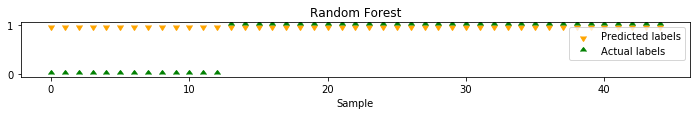

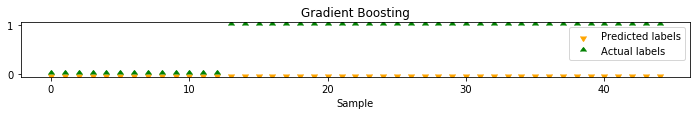

	scenario 4 -> training with real {0, 1, 2, 3} + simulated instances


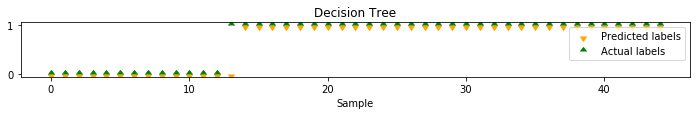

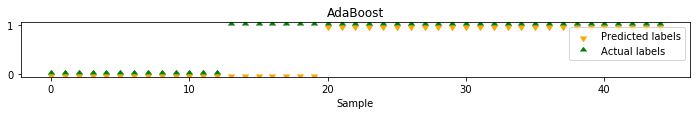

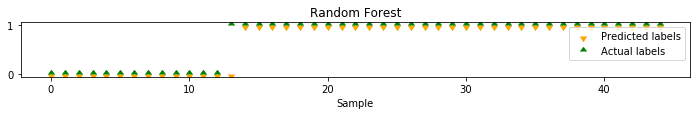

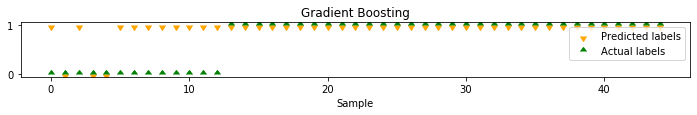

	scenario 5 -> training with real {0, 1, 2, 3} + drawn instances


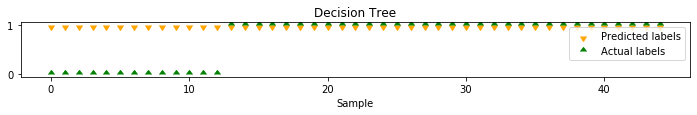

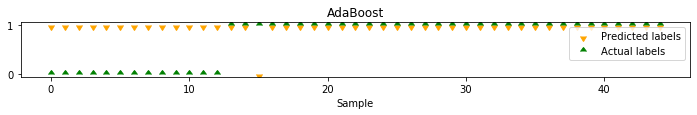

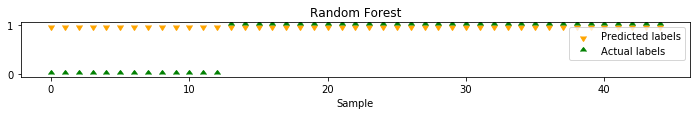

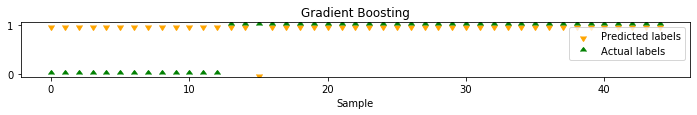

	scenario 6 -> training with simulated + drawn instances


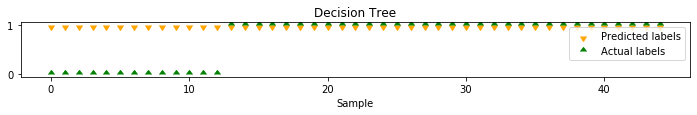

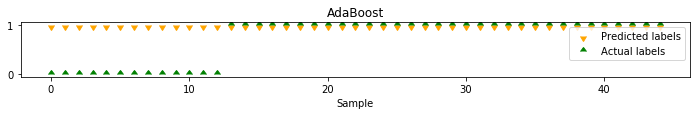

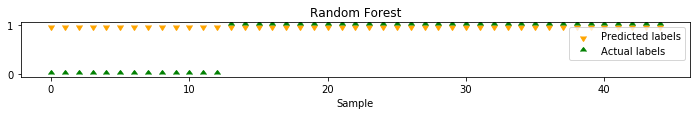

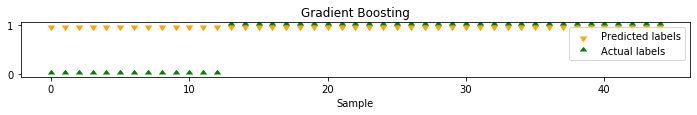

	scenario 7 -> training with real {0, 1, 2, 3} + simulated + drawn instances


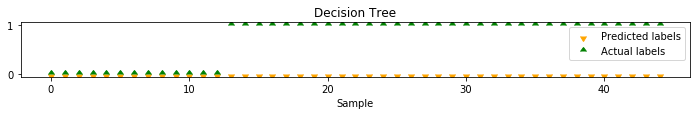

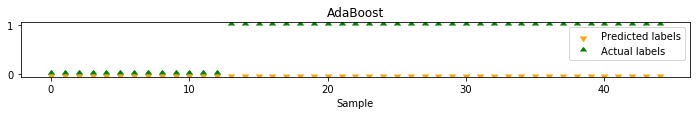

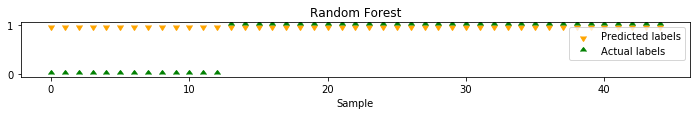

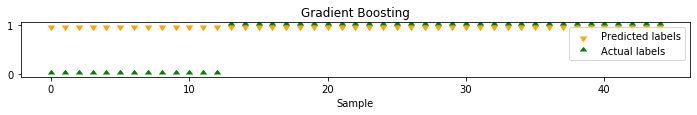

In [25]:
# For each round of a cross-validation with the 'leave one instance out' schema
cols = ['SCENARIO', 'CLASSIFIER', 'F1', 'PRECISION', 'RECALL', 'TRAINING[s]', 'TESTING[s]']
scores = pd.DataFrame(columns=cols)
scores['SCENARIO'] = scores['SCENARIO'].astype(int)
add_real = [True, False, False, True, True, False, True]
add_source = {0: [],
              1: ['simulated'],
              2: ['drawn'],
              3: ['simulated'],
              4: ['drawn'],
              5: ['simulated', 'drawn'],
              6: ['simulated', 'drawn']}
added_source = ['', 
                'simulated', 
                'drawn', 
                'simulated', 
                'drawn',
                'simulated + drawn',
                'simulated + drawn']
scaler = preprocessing.StandardScaler()
for train_i, test_i in loio(len(real_instances)):
    print('current testing instance: {}'.format(list(test_i)[0]))

    # Drops the bad vars
    idxs = (df_instances['source']=='real') & (df_instances['instance_id'].isin(train_i))
    good_vars = np.isnan(df_instances.loc[idxs][vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_instances.loc[idxs][vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_instances_good_vars = df_instances.drop(columns=bad_vars, errors='ignore')
    
    # For each considered scenario
    for s in range(len(add_source)):
        idxs_test = (df_instances_good_vars['source']=='real') & \
                    (df_instances_good_vars['instance_id'].isin(test_i))
        if add_real[s]:
            print('\tscenario {} -> training with real {} + {} instances'.format(s+1, train_i, added_source[s]))
            idxs_train = (df_instances_good_vars['source']=='real') & \
                         (df_instances_good_vars['instance_id'].isin(train_i))
        else:
            print('\tscenario {} -> training with {} instances'.format(s+1, added_source[s]))
            idxs_train = df_instances_good_vars['source'].isin(['NoSource']) # Series with only False itens
        idxs_train |= df_instances_good_vars['source'].isin(add_source[s])
        #print('# observations in idxs_test: {}'.format(sum(idxs_test)))
        #print('# observations in idxs_train: {}'.format(sum(idxs_train)))

        df_instances_test  = df_instances_good_vars.loc[idxs_test].reset_index(drop=True)
        df_instances_train = df_instances_good_vars.loc[idxs_train].reset_index(drop=True)
        
        df_instances_train[good_vars] = scaler.fit_transform(df_instances_train[good_vars])
        df_instances_test[good_vars] = scaler.transform(df_instances_test[good_vars])
        
        df_samples_train = pd.DataFrame()
        df_samples_test  = pd.DataFrame()
        df_y_train = pd.DataFrame()
        df_y_test  = pd.DataFrame()
        sample_id = 0
        
        # Extracts samples from each training instance
        for instance in set(df_instances_train['instance_id']):
            #print('extracting samples from instance {}'.format(instance))            
            df = df_instances_train.loc[df_instances_train['instance_id']==instance]
            ret = extract_samples_train(df, df_samples_train, df_y_train, sample_id)
            df_samples_train, df_y_train, sample_id = ret

        # Extracts samples from the testing instance            
        ret = extract_samples_test(df_instances_test, df_samples_test, df_y_test, sample_id)
        df_samples_test, df_y_test, sample_id = ret
        
        # Drops the unnecessary columns
        df_samples_train = df_samples_train.drop(['instance_id'], axis=1)
        df_samples_test  = df_samples_test.drop(['instance_id'], axis=1)
        
        # Changes types of the good vars to avoid problems with inf
        df_samples_train[good_vars] = df_samples_train[good_vars].astype('float32')
        df_samples_test[good_vars]  = df_samples_test[good_vars].astype('float32')
                
        # Changes types of the labels (tsfresh's requirement)
        y_train = np.array(df_y_train['y'], dtype=int)
        y_test  = np.array(df_y_test['y'], dtype=int)
        
        # Groups the transient and the in-regime periods as undesirable event
        y_train[y_train==100+undesirable_event_code] = undesirable_event_code
        y_test[y_test  ==100+undesirable_event_code] = undesirable_event_code
        
        # Extracts features from samples
        X_train = extract_features(df_samples_train, 
                                   column_id='id', 
                                   column_sort='timestamp', 
                                   default_fc_parameters=df_fc_p,
                                   impute_function=impute,
                                   n_jobs=0,
                                   disable_progressbar=disable_progressbar)
        X_train = X_train.reset_index(drop=True)
        X_test = extract_features(df_samples_test, 
                                  column_id='id', 
                                  column_sort='timestamp',
                                  default_fc_parameters=df_fc_p,
                                  impute_function=impute,
                                  n_jobs=0,
                                  disable_progressbar=disable_progressbar)
        X_test = X_test.reset_index(drop=True) 
        
        # Trains, tests and calculates the scores
        scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs, s+1) 

# 3. Results

The results obtained with the implemented method are presented below.

In [16]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['median', 'mean', 'standard_deviation', 'variance', 'maximum', 'minimum']


The following commands conveniently permit saving and retrieving the results to/from a CSV file.

In [26]:
scores.to_csv(r'./demo_1_benchmark_impact_of_using_simulated_and_hand-drawn_instances_scores.csv')
#scores = pd.read_csv(r'./demo_1_benchmark_impact_of_using_simulated_and_hand-drawn_instances_scores.csv', index_col=0)

# 3.1. Metrics in Tabular Format

The following tables present the averages and standard deviation, respectively, of the metrics grouped by scenario and sorted by F1.

In [17]:
score_table = scores.drop(['CLASSIFIER'], axis=1).groupby(['SCENARIO']).mean().sort_values(by=['F1'], ascending=False)
score_table

,F1,PRECISION,RECALL,TRAINING[s],TESTING[s]
SCENARIO,,,,,
5,0.904444,0.904444,0.904444,0.053979,0.001696
4,0.883333,0.883333,0.883333,0.364041,0.001759
2,0.848889,0.848889,0.848889,0.383833,0.001839
6,0.798889,0.798889,0.798889,0.410322,0.001769
7,0.760000,0.760000,0.760000,0.388131,0.001790
3,0.606667,0.606667,0.606667,0.045123,0.001701
1,0.498889,0.498889,0.498889,0.026120,0.001725


In [18]:
score_table = scores.drop(['CLASSIFIER'], axis=1).groupby(['SCENARIO']).std().sort_values(by=['F1'], ascending=True)
score_table

,F1,PRECISION,RECALL,TRAINING[s],TESTING[s]
SCENARIO,,,,,
5,0.131389,0.131389,0.131389,0.049373,0.001706
2,0.137857,0.137857,0.137857,0.365368,0.001876
4,0.221974,0.221974,0.221974,0.332907,0.001672
6,0.230430,0.230430,0.230430,0.382114,0.001728
7,0.300452,0.300452,0.300452,0.361136,0.001760
3,0.367638,0.367638,0.367638,0.040059,0.001726
1,0.405644,0.405644,0.405644,0.023193,0.001809


The following tables present the averages and standard deviation, respectively, of the metrics grouped by classifier and sorted by F1.

In [19]:
score_table = scores.drop(['SCENARIO'], axis=1).groupby(['CLASSIFIER']).mean().sort_values(by=['F1'], ascending=False)
score_table

,F1,PRECISION,RECALL,TRAINING[s],TESTING[s]
CLASSIFIER,,,,,
Random Forest,0.824762,0.824762,0.824762,0.033968,0.001230
Gradient Boosting,0.786667,0.786667,0.786667,0.513818,0.000628
AdaBoost,0.785397,0.785397,0.785397,0.384181,0.004662
Decision Tree,0.632381,0.632381,0.632381,0.023204,0.000498


In [20]:
score_table = scores.drop(['SCENARIO'], axis=1).groupby(['CLASSIFIER']).std().sort_values(by=['F1'], ascending=True)
score_table

,F1,PRECISION,RECALL,TRAINING[s],TESTING[s]
CLASSIFIER,,,,,
Random Forest,0.249023,0.249023,0.249023,0.021565,0.000088
Gradient Boosting,0.267113,0.267113,0.267113,0.382560,0.000058
AdaBoost,0.269427,0.269427,0.269427,0.276557,0.000352
Decision Tree,0.384271,0.384271,0.384271,0.019997,0.000080


# 3.2. Non-Parametric Multiple Comparison Analysis

The following output (p_value < 5%) reveals that the null-hypothesis that all scenarios have the same performance is false. That means that at least one of them have, with high probability, different F1 mean values compared to the others.

In [21]:
c_names = [c+1 for c in add_source.keys()]
f1s = [scores.loc[scores['SCENARIO']==cn, 'F1'].values for cn in c_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print('p_value: {}'.format(p_value))

p_value: 0.001709469921214568


Now we investigate which scenarios have statistically different F1 mean values compared to the scenario 1 (training with real instance only). The p_values and adj_p_values indicate that scenarios 4 and 5 have statistically better performances, with high probability, compared to the scenario 1 (< 5%).

In [22]:
c_names_2 = ['scenario {}'.format(cn) for cn in c_names]
ret = stac.holm_test(len(pivots), pivots, c_names_2, c_names_2.index('scenario 1'))
comp, z_values_stat, p_values, adj_p_values = ret
for i in range(len(comp)):
    print('{}: \n\tp_values: {}\n\tadj_p_values: {}'.format(comp[i], p_values[i], adj_p_values[i])) 

scenario 1 vs scenario 4: 
	p_values: 0.0006654022432110995
	adj_p_values: 0.003992413459266597
scenario 1 vs scenario 5: 
	p_values: 0.0012798047930306922
	adj_p_values: 0.006399023965153461
scenario 1 vs scenario 2: 
	p_values: 0.06727796053834889
	adj_p_values: 0.26911184215339556
scenario 1 vs scenario 7: 
	p_values: 0.0922923390340733
	adj_p_values: 0.2768770171022199
scenario 1 vs scenario 6: 
	p_values: 0.11557096219724294
	adj_p_values: 0.2768770171022199
scenario 1 vs scenario 3: 
	p_values: 0.7418788559147753
	adj_p_values: 0.7418788559147753


The following output (p_value > 5%) reveals that the null-hypothesis that all classifiers have the same performance cannot be rejected. That means that all classifiers have, with high probability, statistically compatible F1 mean values.

In [23]:
c_names = [c for c in clfs.keys()]
f1s = [scores.loc[scores['CLASSIFIER']==cn, 'F1'].values for cn in c_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print('p_value: {}'.format(p_value))

p_value: 0.2787227143117432


# 3.3. Metrics in Boxplots

The boxplots presented below are ordered by F1 mean values of the considered scenarios.

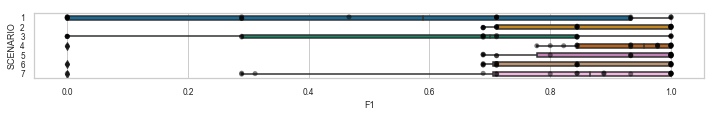

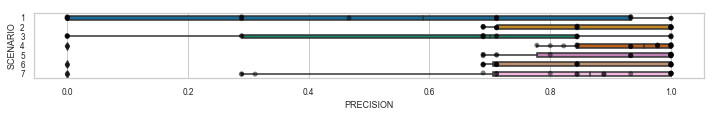

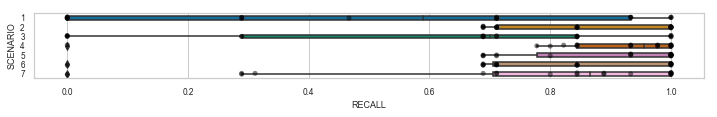

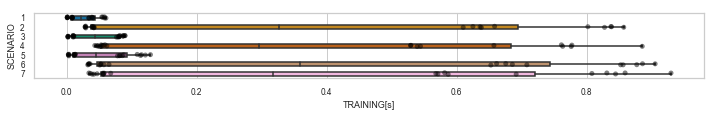

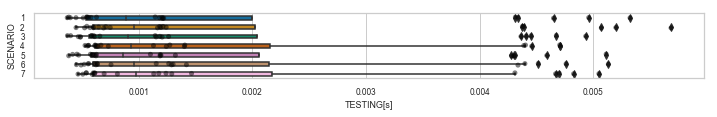

In [24]:
sns.set(font_scale=0.75, style="whitegrid")
for score in scores.columns.drop(['CLASSIFIER', 'SCENARIO']):
    plt.figure(figsize=(12,1.2))
    bplot=sns.boxplot(y='SCENARIO', x=score, data=scores, width=0.4,
                      palette='colorblind', orient='h');
    bplot=sns.stripplot(y='SCENARIO', x=score, data=scores, jitter=True, marker='o',
                        alpha=0.5, color='black', orient='h')

The boxplots presented below are ordered by F1 mean values of the considered classifiers.

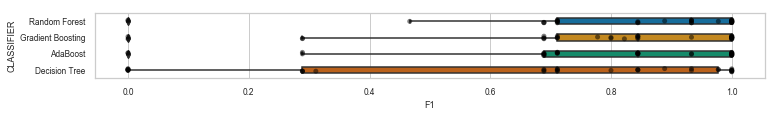

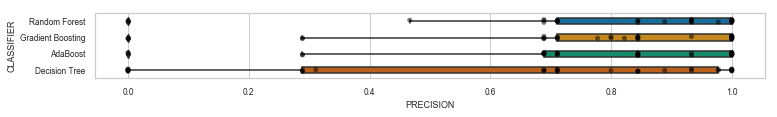

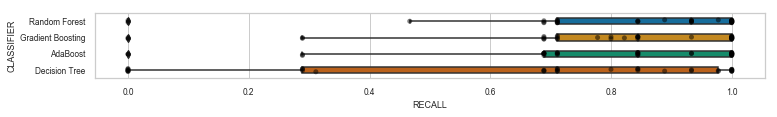

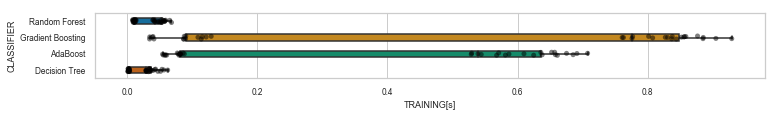

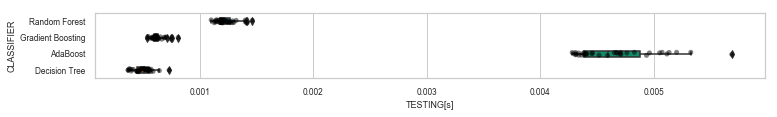

In [25]:
sns.set(font_scale=0.75, style="whitegrid")
for score in scores.columns.drop(['CLASSIFIER', 'SCENARIO']):
    plt.figure(figsize=(12,1.2))
    bplot=sns.boxplot(y='CLASSIFIER', x=score, data=scores, width=0.4,
                      palette='colorblind', order=list(score_table.index), orient='h');
    bplot=sns.stripplot(y='CLASSIFIER', x=score, data=scores, jitter=True, marker='o',
                        alpha=0.5, color='black', order=list(score_table.index), orient='h')

# 4. Conclusion

Given the results presented above, we can state that the classifier "Random Forest" presents better performance in terms of averages and standard deviation of the metrics F1, PRECISION and RECALL, but not in terms of the times for training and testing. We also can state that the scenario 1 produces the worst performances related to the averages and standard deviation of the metrics F1, PRECISION and RECALL.

After a non-parametric multiple comparison analysis, we verified that all classifiers have, with high probability, statistically compatible F1 mean values. We also verified that two scenarios 4 (training with real and simulated instances) and 5 (training with real and hand-drawn instances) have statistically better performances, with high probability, compared to the scenario 1 (training with real instance only).

Therefore, we can state that using simulated and hand-drawn instances in machine learning algorithm training, specially together with real instances, has a positive impact for anomaly detections in other real instances.